# Problem Set 5, due March 8 at 11:59am, mid-day, noon.

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early! Part 4 will give you an opportunity to get some intuition with PCA.

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from  sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's likely [Oscar winner](http://www.rottentomatoes.com/m/the_revenant_2015/) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [6]:
reviews = pd.read_csv("C:/Users/iGuest/Downloads/reviews.csv")
movies = pd.read_csv("C:/Users/iGuest/Downloads/movies.dat", delimiter='\t')


reviews = reviews[~reviews.quote.isnull()]
# Remove rows where critic value is null
reviews = reviews[~reviews.critic.isnull()]
 # Remove rows where fresh value is not given
reviews = reviews[reviews.fresh != 'none']
# Consider only those rows of quote that have some text
reviews = reviews[reviews.quote.str.len() > 0]

### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [7]:
# enter your code below
print ("Number of reviews: %i" % len(reviews))
print ("Number of unique reviews: %i" %pd.unique(reviews["quote"]).shape)
print ("Number of unique reviewers: %i" %pd.unique(reviews["critic"]).shape)
print ("Number of unique movies in reviews dataset: %i" %pd.unique(reviews["title"]).shape)
print ("Number of unique movies in movies dataset: %i" %pd.unique(movies["title"]).shape)
print ("Number of different publications in reviews dataset: %i" %pd.unique(reviews["publication"]).shape)

Number of reviews: 12718
Number of unique reviews: 12149
Number of unique reviewers: 540
Number of unique movies in reviews dataset: 1715
Number of unique movies in movies dataset: 9405
Number of different publications in reviews dataset: 64


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

In [8]:
plt.figure()
review_critics = reviews.groupby(['critic']).count()

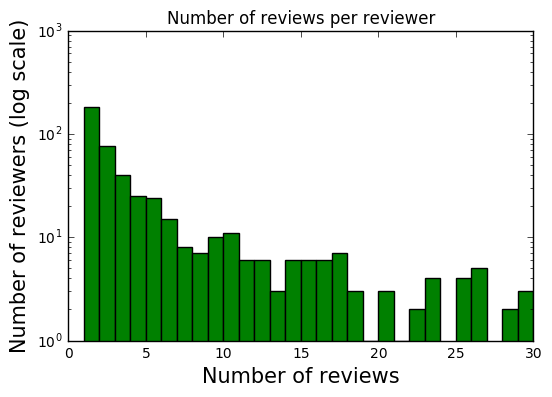

In [9]:
plt.figure()
review_critics = reviews.groupby(['critic']).count()

plt.hist(review_critics["fresh"], range=[0,30], bins=(30), facecolor='green', edgecolor='black')

plt.yscale('log')
plt.title("Number of reviews per reviewer")
plt.ylabel("Number of reviewers (log scale)", fontsize = 15)
plt.xlabel("Number of reviews", fontsize=15)

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [10]:
# Remove the timestamp vale from the date column
reviews["review_date"] =  pd.to_datetime(reviews["review_date"])

# Find unique publications and unique quotes from the reviews dataset
aggregations = {
    "review_date": [np.min, np.max],
    "publication": lambda x : list(pd.unique(x)),
    "quote": lambda x : len(x)
}
aggregations

{'publication': <function __main__.<lambda>>,
 'quote': <function __main__.<lambda>>,
 'review_date': [<function numpy.core.fromnumeric.amin>,
  <function numpy.core.fromnumeric.amax>]}

In [12]:
# Get a table of aggregated review dates, quote and publication
reviews.groupby(["critic"], as_index=False).agg(aggregations).sort_values([('quote', '<lambda>')], ascending=False).head(30)

critic review_date             \
                               amin       amax   
453         Roger Ebert  2000-01-01 2013-06-11   
220  James Berardinelli  1800-01-01 2012-02-07   
228        Janet Maslin  2000-01-01 2010-09-07   
529       Variety Staff  2001-02-13 2012-08-15   
285  Jonathan Rosenbaum  1988-07-11 2013-10-22   
145      Desson Thomson  2000-01-01 2012-10-08   
194        Geoff Andrew  2005-08-11 2012-04-05   
121           Dave Kehr  2000-01-01 2013-11-20   
307       Kenneth Turan  2000-01-01 2013-10-05   
374        Mick LaSalle  2000-01-01 2009-11-25   
397     Owen Gleiberman  1800-01-01 2011-09-07   
440        Rita Kempley  2000-01-01 2013-11-02   
255         Joe Baltake  2000-01-01 2013-08-04   
514       Todd McCarthy  2000-01-01 2012-10-09   
531       Vincent Canby  2000-01-01 2013-07-29   
203          Hal Hinson  2000-01-01 2013-06-26   
498         Susan Stark  2000-01-01 2002-10-25   
488      Stephen Holden  2000-01-01 2009-02-06   
142         Derek Adams  2006-01-26 2009-10-04   
314        Kevin Thomas  2000-01-01 2013-11-02   
414         Peter Stack  2000-01-01 2002-06-18   
58      Bosley Crowther  2000-01-01 2008-05-06   
439          Rick Groen  2002-03-19 2009-08-14   
157     Edward Guthmann  2000-01-01 2003-04-04   
337    Lisa Schwarzbaum  1979-01-01 2012-08-15   
331          Liam Lacey  2001-08-24 2012-04-04   
167        Emanuel Levy  2000-01-01 2010-08-06   
438    Richard Schickel  2000-01-01 2013-08-05   
429     Richard Corliss  2003-12-16 2013-11-06   
372  Michael Wilmington  2000-01-01 2013-11-21   

                                           publication    quote  
                                              <lambda> <lambda>  
453                 [Chicago Sun-Times, At the Movies]     1150  
220                                        [ReelViews]      833  
228                                   [New York Times]      526  
529                                          [Variety]      449  
285                                   [Chicago Reader]      420  
145                                  [Washington Post]      373  
194                                         [Time Out]      361  
121  [Chicago Reader, New York Daily News, Chicago ...      360  
307                                [Los Angeles Times]      282  
374                          [San Francisco Chronicle]      280  
397                             [Entertainment Weekly]      241  
440                                  [Washington Post]      236  
255  [Sacramento Bee, Passionate Moviegoer, Philade...      231  
514                                          [Variety]      223  
531                                   [New York Times]      207  
203                                  [Washington Post]      174  
498                                     [Detroit News]      167  
488                                   [New York Times]      166  
142                                         [Time Out]      154  
314                                [Los Angeles Times]      145  
414                          [San Francisco Chronicle]      138  
58                                    [New York Times]      137  
439                                   [Globe and Mail]      129  
157                          [San Francisco Chronicle]      121  
337                             [Entertainment Weekly]      117  
331                                   [Globe and Mail]      111  
167                                          [Variety]      110  
438                      [TIME Magazine, The Atlantic]      106  
429                                    [TIME Magazine]      104  
372               [Chicago Tribune, Los Angeles Times]      103

### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

In [13]:
# enter your code here
movies.head()
#Get critic ratings by year
ratings_byTime = movies[["year","rtAllCriticsRating"]]
ratings_byTime = ratings_byTime.convert_objects(convert_numeric=True)
#Remove rows with rating value 0 (zero)
ratings_byTime = ratings_byTime[ratings_byTime["rtAllCriticsRating"]!=0]
average_yearly_rating_df = ratings_byTime.groupby("year", as_index=False).mean()

C:\Users\iGuest\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


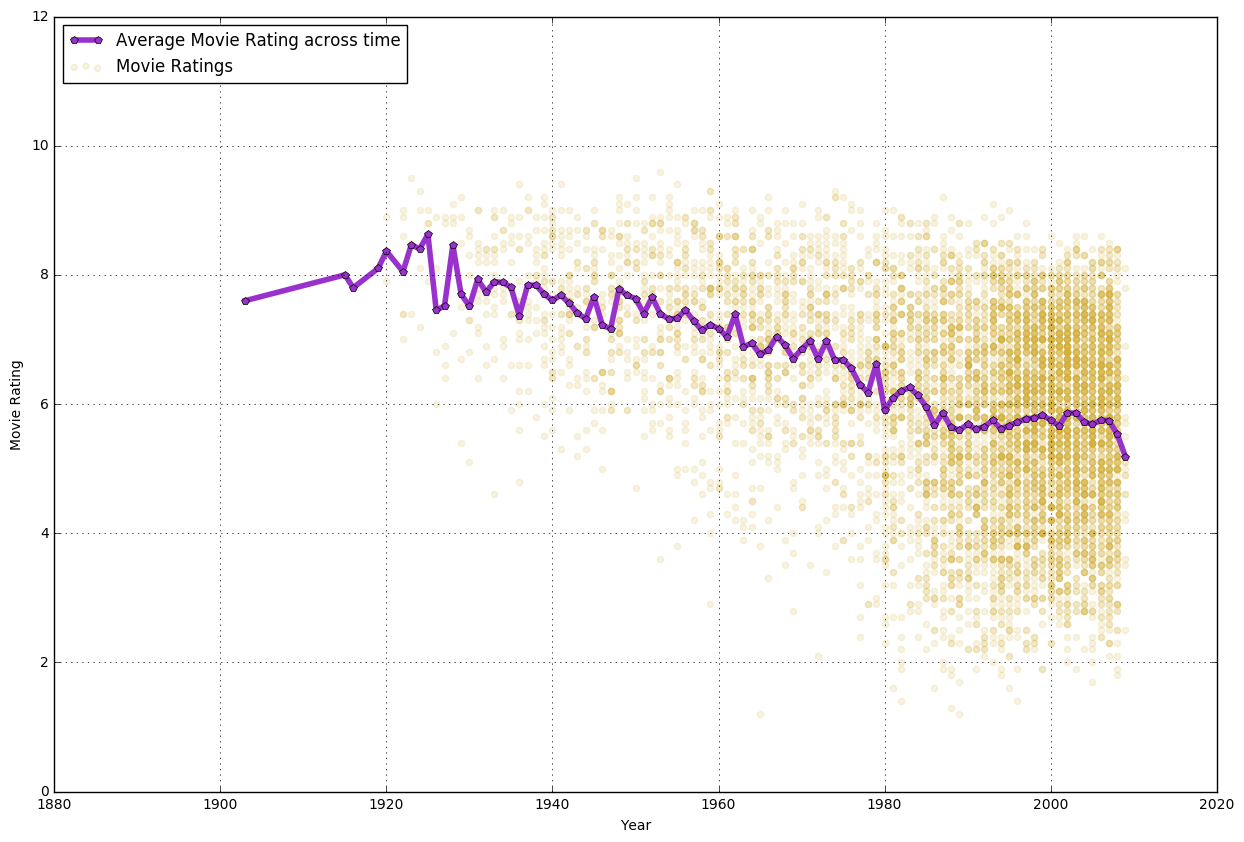

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.grid(True)

# Scatter plot of movie ratings by year
ax.scatter(ratings_byTime["year"], ratings_byTime["rtAllCriticsRating"], alpha=0.15, color='#D4AF37', label ="Movie Ratings")
ax.plot(average_yearly_rating_df["year"],average_yearly_rating_df["rtAllCriticsRating"], color = "#9932CC", marker = "p", linestyle = "-" ,linewidth = 4,  label ="Average Movie Rating across time")
plt.ylabel("Movie Rating")
plt.xlabel("Year")
plt.legend(loc="upper left")

Observations:
1.The plot shows years vs movie ratings over the years
2.It can be seen that the number of movies are increasing exponentially
3.There is a general trend of movie ratings falling each year with some fluctuations during 1978 and some stable ratings in around 1985 to 1999

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print ("Original text is\n", '\n'.join(text))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print
print ("Transformed text vector is \n", x)

# `get_feature_names` tracks which word is associated with each column of the transformed x
print
print ("Words for each feature:")
print (vectorizer.get_feature_names())

Original text is
 machine learning rocks
machine learning rules
rocks rocks rules
Transformed text vector is 
 [[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]
Words for each feature:
['learning', 'machine', 'rocks', 'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [16]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(df, vectorizer=None):
    review_text = list(df["quote"])
    
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df=0)

    # call `fit` to build the vocabulary
    vectorizer.fit(review_text)

    # call `transform` to convert text to a bag of words
    X = vectorizer.transform(review_text)

    # CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
    # convert back to a "normal" numpy array
    X = X.toarray()
    
    Y = pd.DataFrame(df["fresh"])
    Y.loc[Y["fresh"] == "fresh","fresh"] = 1
    Y.loc[Y["fresh"] == "rotten","fresh"] = 0
    Y = np.array(Y).reshape(len(Y))
    Y = Y.astype(int)
    
    return X, Y

In [17]:
X, Y = make_xy(reviews)

### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set and a validation set.  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [18]:
#create test and train
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.34, random_state = 2)

### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [19]:
# call the fitted model fitted_model, for future reference:
model1 = MultinomialNB().fit(X_train, y_train)

In [21]:
from sklearn import metrics
# Make predictions on the test set
y_prediction_test = model1.predict(X_test)
y_prediction_train = model1.predict(X_train)
# Compute accuracy by comparing predicted and actual values
print ("Accuracy on the test set: %s"%(metrics.accuracy_score(y_test, y_prediction_test)))
print ("Accuracy on the train set: %s"%(metrics.accuracy_score(y_train, y_prediction_train)))

Accuracy on the test set: 0.761849710983
Accuracy on the train set: 0.930656499464


Observations from above:
1.The model shows prediction of train data into fresh or rotten movie reviews
2.The train data accuracy is much higher than the test data accuracy
3.This is indicative that the train data could be over-fitted

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [ ]:
# Your code here

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [22]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""
def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# chance the nambes of the variables below to match your code in 2.2 and 2.3
log_likelihood(model1, X_train, y_train)

-1483.4900192346713

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [23]:
import time
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha_NB = None
best_min_df_NB = None
max_loglike = -np.inf

start_time = time.time()

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        fitted_model = MultinomialNB(alpha = alpha)
        #log_like = log_likelihood(fitted_model, X, Y)
        score = cross_val_score(fitted_model, X, Y, cv = 3, scoring=log_likelihood)
        if score.mean() > max_loglike:
            max_loglike = score.mean()
            best_alpha_NB = alpha
            best_min_df_NB = min_df
            
print ("Time taken: " + str(round(time.time() - start_time,2)) + " seconds")
print (best_alpha_NB)
print (best_min_df_NB)
print (max_loglike)

Time taken: 326.11 seconds
5
0.001
-2353.07320543


### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [24]:
vectorizer = CountVectorizer(best_min_df_NB)
X, Y = make_xy(reviews,vectorizer)

#create test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.34, random_state = 5)

# call the fitted model fitted_model:
model1 = MultinomialNB(alpha = best_alpha_NB).fit(X_train, y_train)

# make predictions on the testing set
y_predicted = model1.predict(X_test)

# compare actual response values with predicted values
print (metrics.accuracy_score(y_test, y_predicted))

0.678150289017


Observation from above:
The new model after cross validation is less accurate with 67.78% as compared to the previous model with 76% accuracy
But, the over-fitting is less too. It is more generalizable as it takes into account only the important relationships in data
Thus, the new model is better out of the 2 models

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [4]:
#Enter your code here

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [25]:
# Enter your code here
vectorizer = CountVectorizer(min_df = best_min_df_NB, stop_words="english")
vectorizer.fit(list(reviews["quote"]))

X, Y = make_xy(reviews,vectorizer)

# call the fitted model fitted_model
fitted_model = MultinomialNB(alpha = best_alpha_NB).fit(X, Y)

# Extract feature names to feature_words array
feature_words = vectorizer.get_feature_names()

#identity matrix
X_identity = np.identity(len(feature_words))

# Compute predicted probablity
Y_prob = fitted_model.predict_proba(X_identity)

In [26]:
#create data frame of words with Fresh and Rotten probabilities
words_df = pd.DataFrame({"Word": feature_words, 
                         "Probability Fresh":list(Y_prob[:,1]), "Probability Rotten":list(Y_prob[:,0])})

In [27]:
print ("\n10 words which best predict a fresh review : \n")
print (words_df[["Probability Fresh","Word"]].sort_values("Probability Fresh", ascending=False).head(10))
print ("\n10 words which best predict a rotten review : \n")
print (words_df[["Probability Rotten","Word"]].sort_values("Probability Rotten", ascending=False).head(10))


10 words which best predict a fresh review : 

      Probability Fresh           Word
425            0.905297        delight
1076           0.903396    masterpiece
1798           0.876923       touching
905            0.875213    intelligent
1382           0.874844           rare
1703           0.871032         superb
1414           0.871032     remarkable
1684           0.867220       stunning
1955           0.865631          witty
601            0.864550  extraordinary

10 words which best predict a rotten review : 

      Probability Rotten            Word
1850            0.882888   unfortunately
972             0.856465            lame
1299            0.843493       pointless
1852            0.833459      uninspired
167             0.827943           bland
467             0.806593  disappointment
1851            0.806593         unfunny
1787            0.801671        tiresome
499             0.800980            dull
1470            0.785277           sadly


Observation:
The 10 words that best predict the value of fresh and rotten reviews are listed above.

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [28]:
#Your code here
#create dataframe with predicted probabilities & classification and actual classification 
reviews_cls_df = pd.DataFrame({"Review Text":reviews["quote"],
                                "Probablity-Fresh":fitted_model.predict_proba(X)[:,1],
                                "Probablity-Rotten":fitted_model.predict_proba(X)[:,0],
                                "Predicted Classification":fitted_model.predict(X),
                               "Actual Classification":Y})

In [29]:
#Sort the reviews for fresh review values and print first 5 in ascending order
print ("Top 5 Reviews that were classified as rotten but were actually fresh : \n")
reviews_cls_df[reviews_cls_df["Actual Classification"]==1].sort_values("Probablity-Rotten",ascending=False).head(5)

Top 5 Reviews that were classified as rotten but were actually fresh : 



,Actual Classification,Predicted Classification,Probablity-Fresh,Probablity-Rotten,Review Text
5400,1,0,0.006867,0.993133,"Some of the gags don't work, but fewer than in..."
9833,1,0,0.014737,0.985263,The real question with Rocky III was how Sylve...
670,1,0,0.018304,0.981696,A good half-hour's worth of nonsense in the mi...
5109,1,0,0.023435,0.976565,"I saw this at a festival and hated it, then sa..."
13261,1,0,0.028518,0.971482,"Supernova, though predictable, isn't half bad."


In [30]:
#Sort the reviews for rotten review values and print first 5 in ascending order
print ("Top 5 Reviews that were classified as fresh but were actually rotten : \n")
reviews_cls_df[reviews_cls_df["Actual Classification"]==0].sort_values("Probablity-Fresh",ascending=False).head(5)

Top 5 Reviews that were classified as fresh but were actually rotten : 



,Actual Classification,Predicted Classification,Probablity-Fresh,Probablity-Rotten,Review Text
4133,0,1,0.992578,0.007422,The Disney organization is worst when it makes...
9800,0,1,0.990614,0.009386,Pale Rider does nothing to disprove the wisdom...
13406,0,1,0.986761,0.013239,Benefits from a lively lead performance by the...
11644,0,1,0.986128,0.013872,"At best, it is fun. But ""fun"" is not an aesthe..."
12515,0,1,0.985336,0.014664,This pacifist spirit of brotherhood echoes the...


In [31]:
#create additional row for the example
last_row=pd.DataFrame([['','fresh','','','','This movie is not remarkable, touching, or superb in any way','','','']], 
                  columns=['critic','fresh','imdb','link','publication','quote','review_date','rtid','title'])
#create new reviews data set by appending the last_row
reviews_new=reviews.append(last_row, ignore_index=True)

In [32]:
vectorizer = CountVectorizer(min_df = best_min_df_NB, stop_words='english') 
X, Y = make_xy(reviews_new, vectorizer)
nb = MultinomialNB(alpha=best_alpha_NB)
fitted_model=nb.fit(X,Y)
new_model = fitted_model.predict_proba(X)

print ("The probability of the example text as per the model is = %s"%(new_model[int(new_model.shape[0])-1][1]))

The probability of the example text as per the model is = 0.993085737007


Observations from above:
1.The misclassifications have a very high accuracy. Ths these are considered as Type I and Type II errors
2.The ability of Naive Bayes to predict the probability of each word affects the accuracy of the model
3.Thus, we can see in the example that actually the review is negative but only considering the values of top 10 psoitive words the freshness review gives a very high accuracy which is worng in this case

## Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

In [33]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston
bdata = load_boston()

In [34]:
# Create pandas data frame
boston_df = pd.DataFrame(bdata.data)

# create columns from feature names
boston_df.columns = bdata.feature_names

# Assign medv to target
boston_df['MEDV'] = bdata.target

### 4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

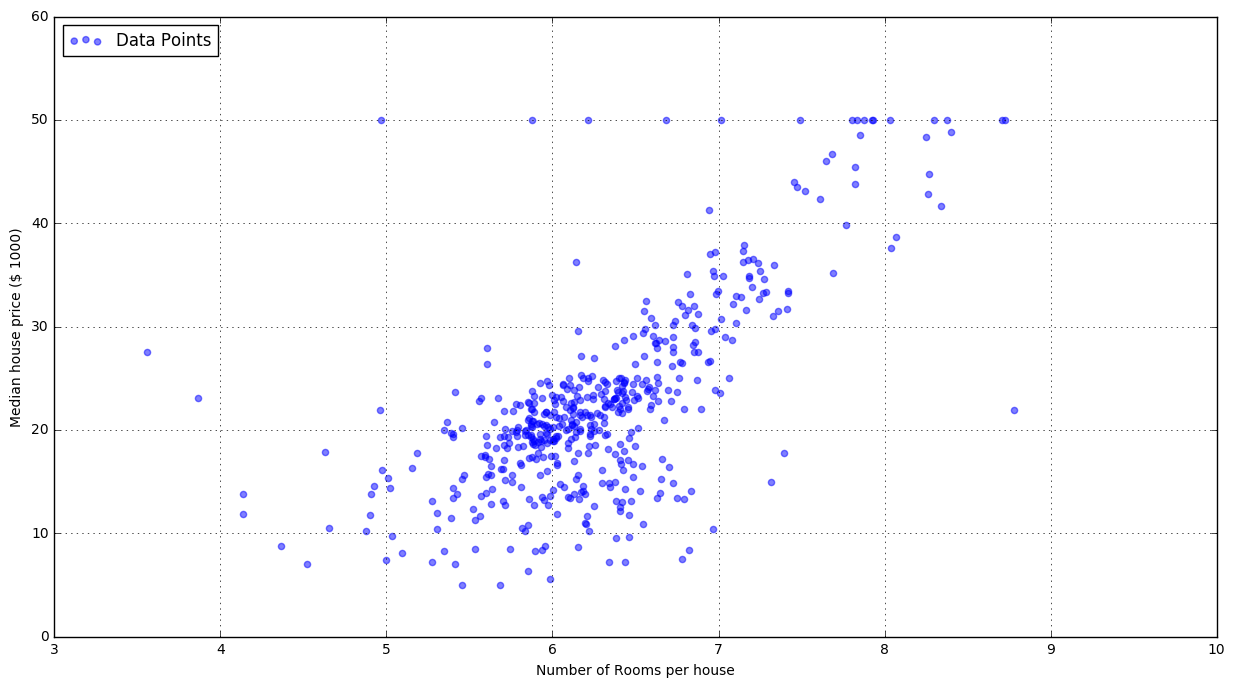

In [35]:
# Enter your code here
fig, ax = plt.subplots(figsize=(15, 8))
ax.grid(True)
# Scatter plot of Median price of houses and per capita income
ax.scatter(boston_df["RM"], boston_df["MEDV"], alpha=0.5, color='blue', label ="Data Points")
plt.ylabel("Median house price ($ 1000)")
plt.xlabel("Number of Rooms per house")
plt.legend(loc="upper left")

In [36]:
X = boston_df["RM"]
y = boston_df["MEDV"]

#creating test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state = 5)

In [37]:
X_train = X_train.reshape(-1,1)
y_train = y_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [38]:
# import the class
from sklearn.linear_model import LinearRegression

# Create an object of class regression
linreg = LinearRegression()

# fit the model with data
linear_model = linreg.fit(X_train, y_train)

# Make predictions on the testing set
y_predicted_test = linear_model.predict(X_test)
y_predicted_train = linear_model.predict(X_train)

In [39]:
# Compute RMSE
def compute_rmse(prediction,yvalues):
    if len(np.array(prediction))==len(np.array(yvalues)):
        rmse = np.sqrt(np.mean((np.array(prediction)-np.array(yvalues))**2))
    else:
        print("array length not equal")
        return -1
    return rmse   

print ("RMSE of the test set = %s"%(compute_rmse(y_predicted_test, y_test)))
print ("RMSE of the train set = %s"%(compute_rmse(y_predicted_train, y_train)))

RMSE of the test set = 7.12181405083
RMSE of the train set = 6.31981824627


Observation from above:
1.The rmse on tarin and test is almost equal which means the model is performing accurately on unseen data
2.This indicates it is not over fitting on train data set

### 4.2 So many scatterplots!

Choose 8 out of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

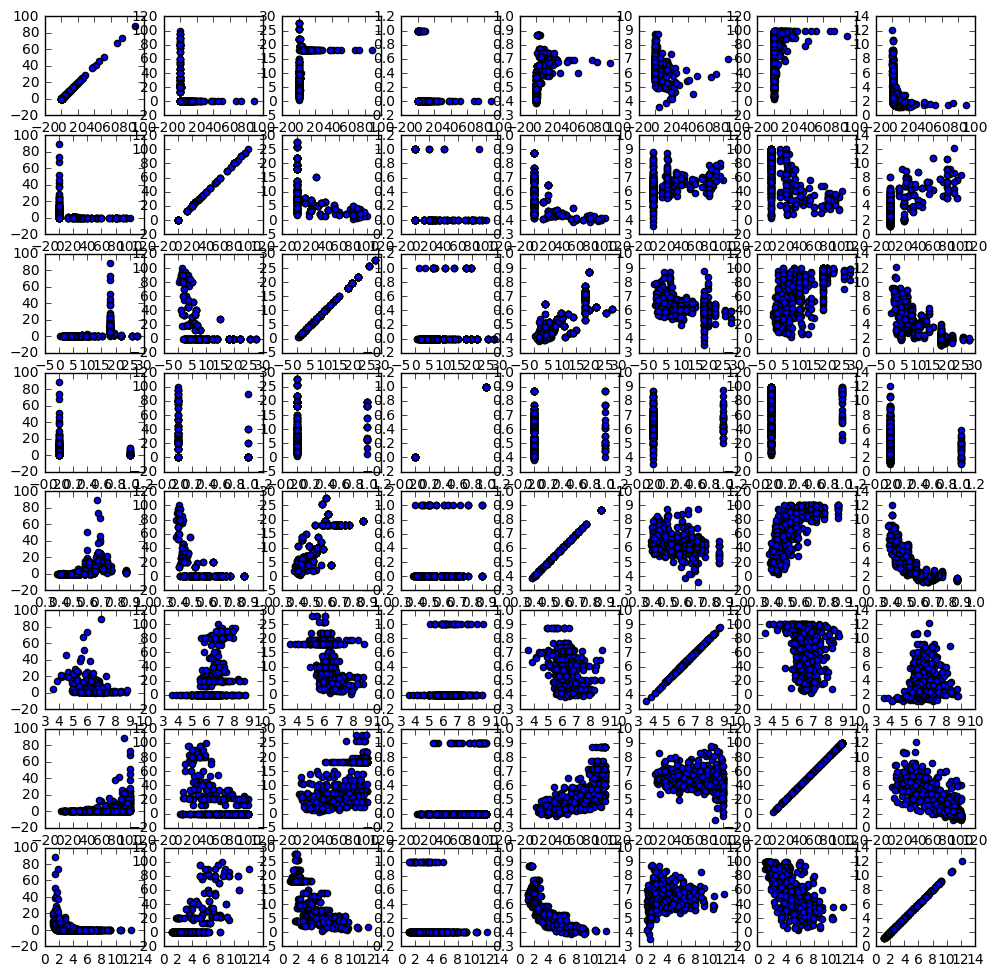

In [40]:
plt.figure(figsize=(12,12))
# Correlation graphs between first 8 variables from the dataset
for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, i * 8 + j + 1)
        plt.scatter(bdata.data[:,i], bdata.data[:,j])

### 4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

In [41]:
# Enter your code here
from sklearn import decomposition

# Standardize the variables
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

#create test and train
X_train, X_test, y_train, y_test = train_test_split(bdata.data, bdata.target, test_size=0.34, random_state = 5)

# Create list to store variances
variances = []

#capturing variance ratios
for i in range(1,12):
    pca = PCA(n_components=i)
    pca.fit(standardize(X_train))
    variances.append(sum(pca.explained_variance_ratio_))

In [42]:
# Plot of PCA and cumulative variance explained
pd.DataFrame(variances).plot(marker = "o", color = "red", figsize= (10,5), label = "line")
plt.legend("%",loc="upper left")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Variance VS PCA graph"

SyntaxError: unexpected EOF while parsing (<ipython-input-42-1a0197679a1c>, line 6)

### 4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

In [ ]:
# Enter your code here
#create a new pca on train data
pca_new = pca.fit_transform(standardize(X_train))

#plot the graphs
plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

#PCA1 VS PCA2
ax1.scatter(pca_new[:,0],pca_new[:,1],color = "red")
ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")
ax1.set_title("PCA1 Vs PCA2")

# Plot of PCA1 Vs Target medv
ax2.scatter(pca_new[:,0],y_train,color = "green")
ax2.set_xlabel("PCA 1")
ax2.set_ylabel("Median prices of homes")
ax2.set_title("PCA 1 Vs MEDV")

# Plot of PCA2 Vs Medv
ax3.scatter(pca_new[:,1],y_train,color = "blue")
ax1.set_xlabel("PCA 2")
ax2.set_ylabel("Median prices of homes")
ax3.set_title("PCA 2 Vs MEDV")

### 4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

In [ ]:
#Extract the principal component only
model = decomposition.PCA(1)
#Project train data on PCA 1
train_projection = model.fit_transform(standardize(X_train))
# Project test data on PCA 1
test_projection = model.fit_transform(standardize(X_test))

#Fit linear regression on projected values and train data
linear_model = LinearRegression()
linear_model.fit(train_projection,y_train)

print (linear_model.coef_[0])
print (linear_model.intercept_)

In [ ]:
train_predicted = linear_model.predict(train_projection)

test_predicted = linear_model.predict(test_projection)

print ("The rmse of training data = %s"%(compute_rmse(train_predicted, y_train)))
print ("The rmse of test data = %s"%(compute_rmse(test_predicted, y_test)))

Observation from above:
1.In 4.1 and 4.5 as well the training and test RMSE is coming almost equivalent to 6.3 to 6.8 for train & test rmse 7.1 to 7.9
2.In the above question, the rmse of test is slightly higher than rmse of train which means the data is over-fitting on training